In [45]:
import os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)
from helper import read_json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [32]:
eval_model = "Qwen2-VL-72B-Instruct"
peft_variant = "qlora_llm_meme_Qwen2-VL-72B-Instruct_multimodal_single_theory_0_shot_train_20_epochs_0.001_lr"
eval_prompt_name = "theory"
result_dir = f"{root_dir}/results/generation/british_complaints/{gen_llm_name}/stable-diffusion-3-medium-diffusers/selective/{eval_model}/{peft_variant}/standard/output"
df = pd.read_csv(f"{root_dir}/resources/datasets/llm_meme/dataset_final.csv")

In [39]:
def get_performance(gen_llm_name, prompt_name):
    result_dir = f"{root_dir}/results/generation/british_complaints/{gen_llm_name}/stable-diffusion-3-medium-diffusers/selective/{eval_model}/{peft_variant}/standard/output"
    best_image_paths = []
    for i in range(1, 51):
        result_file = f"{result_dir}/{i}.json"
        if not os.path.exists(result_file): continue
        result = read_json(result_file)

        max_score = -1
        best_prompt = None
        for key in result:

            if key in ["standard", "lot"]: continue 
            score = result[key]
            
            if score >= max_score:
                max_score = score
                best_prompt = key
        if prompt_name != "best": best_prompt = prompt_name
        best_image_paths.append(f"{gen_llm_name}/stable-diffusion-3-medium-diffusers/{best_prompt}/standard/meme/{i}.png")

    n_funny, n_valid = 0, 0
    for path in best_image_paths:
        rows = df[df["image_path"] == path]
        if len(rows): 
            for i, row in rows.iterrows():
                n_valid += 1
                n_funny += row["Q5_option"] >= 4
    if n_valid == 0: print(gen_llm_name, prompt_name)
    return n_funny / n_valid


In [40]:
get_performance("gpt-4o", "best")

0.26666666666666666

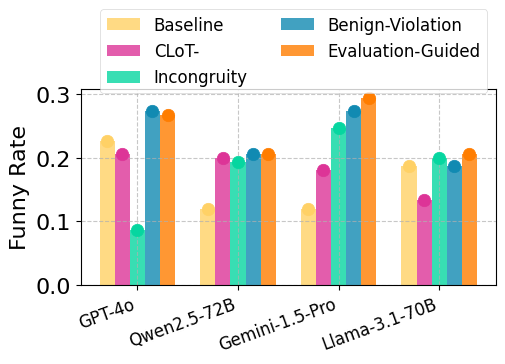

In [131]:
# Define the models and prompts to evaluate
models = {
    "gpt-4o": "GPT-4o", 
    "Qwen2.5-72B-Instruct": "Qwen2.5-72B", 
    # "Mixtral-8x22B-Instruct-v0.1": "Mixtral-8x22B", 
    "gemini-1.5-pro": "Gemini-1.5-Pro", 
    "Llama-3.1-70B-Instruct": "Llama-3.1-70B"
}
prompts = {
    "standard": "Baseline", 
    "lot": "CLoT-",
    "reversal": "Incongruity",
    "benign2": "Benign-Violation",
    "best": "Evaluation-Guided"
}

colors = [
    '#FFD166',
    '#DD3497',
    '#06D6A0',
    '#118AB2',
    '#ff7d00'
]

# Collect performance data for each model and prompt
performance_data = {}
for model in models:
    performance_data[model] = []
    for prompt in prompts:
        if prompt == "best":
            # For "best", we use the best prompt selection logic
            score = get_performance(model, "best")
        else:
            # For specific prompts, we use the prompt name
            score = get_performance(model, prompt)
        performance_data[model].append(score)

# Create a figure with 1x2 subplots (one for each dataset)
fig, ax = plt.subplots(1, 1, sharey=True)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend
fig.subplots_adjust(left=0.16, bottom=0.2, right=0.99, top=0.76, wspace=0.05, hspace=0.15) #margin of the figure
fig.set_size_inches(5, 3.5) #exact size of the figure

# Set width of bars and positions
bar_width = 0.15
index = np.arange(len(models))

# Plot bars for each prompt type
for i, prompt in enumerate(prompts):
    prompt_scores = [performance_data[model][i] for model in models]
    bars = ax.bar(index + i*bar_width, prompt_scores, bar_width, label=prompts[prompt], color=colors[i], alpha = 0.8)
    
    # Add a dot at the top of each bar
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.scatter(bar.get_x() + bar.get_width()/2, height, s=80, zorder=3, color=colors[i])

ax.set_ylabel('Funny Rate', fontsize=16)
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(models.values(), rotation=20, ha='right', fontsize=12)
ax.legend(bbox_to_anchor=(1, 1.45), ncol=2, fontsize=12)
# ax.set_ylim(0, .5)

# Add grid lines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

plt.savefig(f"{root_dir}/figures/generation_results.pdf")
